### Author : Wahid T. Ratul

#### This notebook primarily represents the modeling selection and prediction process for Text Classification using the Covid-19 Tweets. 

This notebook is an extension to --https://github.com/ratul003/Sentiment_Analysis/blob/main/Covid_19Tweets_Viz.ipynb




Contents:

* [1. Libraries](#1)

* [2. Text Cleaning](#2)

* [3. TF-IDF](#3)

* [4. Model Evaluations](#4)

* [5. ROC-AUC](#5)



### [1. Libraries](#1)

In [156]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from io import StringIO
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib in line
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

UsageError: unrecognized arguments: line


In [157]:
# Importing data
train = pd.read_csv('/Users/wahid/Desktop/Python/Text_Classification/Corona_NLP_train.csv', encoding = 'latin1')
test = pd.read_csv('/Users/wahid/Desktop/Python/Text_Classification/Corona_NLP_test.csv.xls', encoding = 'latin1')

test

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [158]:
# Making seperate columns for text
train['text'] = train.OriginalTweet
train['text'] = train['text'].astype(str)

test['text'] = train.OriginalTweet
test['text'] = train['text'].astype(str)

# Data has 5 classes, let's convert into 3 classes:
def classes_def(text):
    if text == 'Extremely Positive':
        return "2"
    if text == 'Extremely Negative':
        return "0"
    if text == 'Negative':
        return "0"
    if text == 'Positive':
        return "2"
    else:
        return "1"

train['label'] = train['Sentiment'].apply(lambda x : classes_def(x))
train
test['label'] = train['Sentiment'].apply(lambda x : classes_def(x))

print(train.label.value_counts(normalize = True))

print("\nWhere by Positive = 2, Neutral = 1 and Negative = 0.")

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

Where by Positive = 2, Neutral = 1 and Negative = 0.


### [2. Text Cleaning](#2)

In [159]:
# Remove URLs and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

# Dataframe without URLs
train['text_new'] = train['text'].apply(lambda x : remove_urls(x))
test['text_new'] = test['text'].apply(lambda x : remove_urls(x))

def remove_html(text):
    html_remove = re.compile(r'<.*?>')
    return html_remove.sub(r'', text)

# Dataframe without HTML links
train['text'] = train['text_new'].apply(lambda x : remove_html(x))
test['text'] = test['text_new'].apply(lambda x : remove_html(x))


# Lower casing
def lower_case(text):
    low_text = text.lower()
    return low_text
    
train['text_new'] = train['text'].apply(lambda x : lower_case(x))
test['text_new'] = test['text'].apply(lambda x : lower_case(x))

# Number removal
def remove_num(text):
    remove = re.sub(r'\d+', '', text)
    return remove

train['text'] = train['text_new'].apply(lambda x : remove_num(x))
test['text'] = test['text_new'].apply(lambda x : remove_num(x))
    

In [160]:
# Remove Stopwords and Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))

def remove_punc(text):
    punc = re.sub(r'[^\w\d\s]', '', text)
    return punc

train['text_new'] = train['text'].apply(lambda x : remove_punc(x))
test['text_new'] = test['text'].apply(lambda x : remove_punc(x))

def remove_stopwords(text): # Split() makes it into an array
    "custom function to remove stopwords"
    return ", ".join([word for word in str(text).split() if word not in STOPWORDS])

train['text'] = train['text_new'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text_new'].apply(lambda x : remove_stopwords(x))



In [161]:
# Remove Mentions and Hashtags
def remove_hash(text):
    hash = re.sub(r'#\w+', '', text)
    return remove_hash

train['text_new'] = train['text'].apply(lambda x : remove_hash(x))
test['text_new'] = test['text'].apply(lambda x : remove_hash(x))

def remove_mention(text):
    mention = re.sub(r'@\w+', '', text)
    return mention

train['text_new'] = train['text'].apply(lambda x : remove_mention(x))
test['text_new'] = test['text'].apply(lambda x : remove_mention(x))


# Removing extra spaces
def remove_spaces(text):
    spaces = re.sub(r'\s+', '', text)
    return spaces

train['text_new'] = train['text'].apply(lambda x : remove_spaces(x))
test['text_new'] = test['text'].apply(lambda x : remove_spaces(x))


train = train.drop(columns = ['text_new'])
test = test.drop(columns = ['text_new'])

train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,"menyrbie, phil_gahan, chrisitv",1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,"advice, talk, neighbours, family, exchange, ph...",2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,"coronavirus, australia, woolworths, give, elde...",2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,"food, stock, one, empty, please, dont, panic, ...",2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"ready, go, supermarket, covid, outbreak, im, p...",0
...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,"airline, pilots, offering, stock, supermarket,...",1
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,"response, complaint, provided, citing, covid, ...",0
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,"know, itâs, getting, tough, kameronwilds, rati...",2
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,"wrong, smell, hand, sanitizer, starting, turn,...",1


### [3. TF-IDF](#3)

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

tf-idf = $\frac{N}{idf}$, where $ idf = \frac{Total  no.  of documents}{No. of documents the word contain}$

Machine learning with natural language is faced with one major hurdle – its algorithms usually deal with numbers, and natural language is, well, text. So we need to transform that text into numbers, otherwise known as text vectorization. TF-IDF score can be fed to algorithms such as Naive Bayes and Support Vector Machines, greatly improving the results of more basic methods like word counts.

In [162]:
# Making the text into a list
x = train['text'].tolist()
y = train['label'].tolist()

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.80,random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf = True, min_df =5, stop_words = 'english')

# We transform each text into a vector
features = tfidf.fit_transform(train.text).toarray()
labels = train.label

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bi-grams)" %(features.shape))


Each of the 41157 tweets is represented by 10615 features (TF-IDF score of unigrams and bi-grams)


### [4. Models](#4)

We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

We will benchmark the following four models:
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest

In [163]:
models = [
    RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 0),
    LinearSVC(),
    MultinomialNB(),
    ]


Cross validation is a technique for assessing how the statistical analysis generalises to an independent data set. It is a technique for evaluating machine learning models by training several models on subsets of the available input data and evaluating them on the complementary subset of the data. Using cross-validation, there are high chances that we can detect over-fitting with ease.

In [164]:
# 5-fold Cross-validation
CV = 2
cv_df = pd.DataFrame(index = range(CV * len(models)))

# Creating a dictionary to return as a list of output
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv = CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

    cv_df = pd.DataFrame(entries, columns = ['Model_name', 'fold_idx', 'accuracy'])
    
cv_df
    

,Model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.453229
1,RandomForestClassifier,1,0.464671
2,LinearSVC,0,0.756305
3,LinearSVC,1,0.759841
4,MultinomialNB,0,0.638029
5,MultinomialNB,1,0.637817


In [165]:
# Model Accuracy Comparison
mean_accuracy = cv_df.groupby('Model_name').accuracy.mean()
std_accuracy = cv_df.groupby('Model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis =1, ignore_index = True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc


,Mean Accuracy,Standard deviation
Model_name,,
LinearSVC,0.758073,0.002500
MultinomialNB,0.637923,0.000150
RandomForestClassifier,0.458950,0.008091


Based on from one of the key indicators of model performance, we can observe that Linear SVM has the highest accuracy of 76%, followed by Naive Bayes and Random Forest Classification.

Accuracy in classification problems is the number of correct predictions made by the model over all kinds predictions made.


* Accuracy = $\frac{True \, + \, Positive \, + \, True \, + \, Negative}{All \, Predictions}$


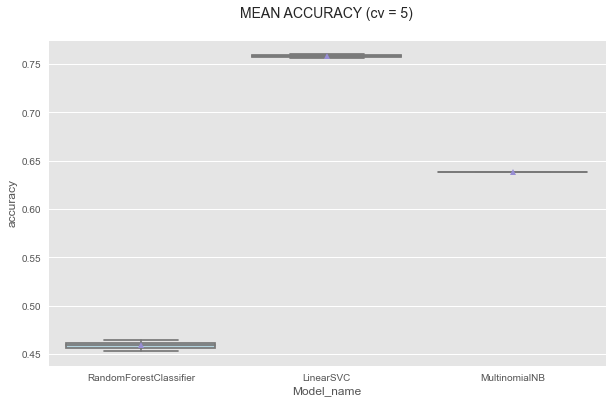

In [166]:
# Graphical Model Comparison
import seaborn as sns
plt.style.use('ggplot')


plt.figure(figsize=(10,6))
sns.boxplot(x='Model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [167]:
# Splitting the testing and training data for model testing 
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                              train.index, test_size=0.80, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [168]:
# Classification Report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print('\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train['label'].unique()))

			CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.73      0.74      0.74     12347
           2       0.58      0.49      0.53      6151
           0       0.75      0.79      0.77     14428

    accuracy                           0.72     32926
   macro avg       0.69      0.67      0.68     32926
weighted avg       0.71      0.72      0.71     32926



We see low F1 scores for Positive (2) tweets as compared to Negative (0) and Neutral (1).

Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive. Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection.

* Precision = $\frac{True \, Positive}{True \, Positive \, + \, False \, Positive}$ OR $\frac{True \, Positive}{All \, Predicted \, Positive}$

Recall measures how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative. For instance, in fraud detection or sick patient detection.

* Recall = $\frac{True \, Positive}{True \, Positive \, + \, False \, Negative}$ OR $\frac{True Positive}{All \, Actual \, Positive}$

F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall unless there is an uneven class distribution between classes. For instance, large number of Actual Negatives.

* F1 score = $2*\frac{Precision \, * \, Recall}{Precision \, + \,Recall}$ --> Harmonic Mean

In [169]:
# Create a new column 'category_id' with encoded categories 

def classes_def(x):
    if x ==  "Extremely Positive":
        return "Positive"
    elif x == "Extremely Negative":
        return "Negative"
    elif x == "Negative":
        return "Negative"
    elif x ==  "Positive":
        return "Positive"
    else:
        return "Neutral"
    

train['Sentiment']= train['Sentiment'].apply(lambda x:classes_def(x))


sentiment_id_df= train[['Sentiment','label']].drop_duplicates()

# Dictionaries for future use


#sentiment_to_id = dict(sentiment_id_df.values)
#id_to_sentiment = dict(sentiment_id_df[['Sentiment','label']].values)


#sentiment_id_df

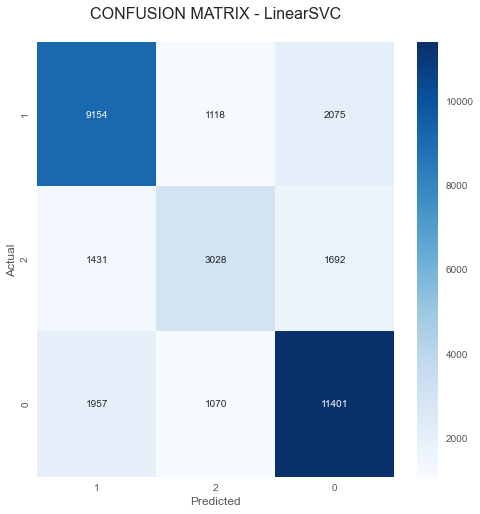

In [170]:
# Confusion Matrix Display
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=sentiment_id_df.label.values, 
            yticklabels=sentiment_id_df.label.values)
#train = train.drop(columns=['Sentiment'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

From the Confusion Matrix, we can observe that majority of the predicted class of the corpus were accurate mostly negative and positive tweets. However, there are few chunks of tweets in the corpus that were not as precise.

### [5. ROC - AUC](#5)

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.

When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.

So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes.



In [171]:
# Splitting the testing and training data for model testing 
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                              train.index, test_size=0.80, 
                                                               random_state=1)
   

In [172]:
xtrain = X_train[1:6000]
ytrain = y_train[1:6000]
xtest= X_test[1:6000]
ytest= y_test[1:6000]



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# roc curve and auc score
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [173]:
d = y_test.unique()
class_name = list(d.flatten())
class_name
from sklearn.linear_model import LogisticRegression

#model = LinearSVC()
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

LRE = LogisticRegression(solver='lbfgs')

LRE.fit(xtrain, ytrain)

LogisticRegression()

In [178]:
for p in class_name:
    fpr0, tpr0, thresholds = metrics.roc_curve(ytest,  
                     LRE.predict_proba(xtest)[:,0], pos_label = p) 

auroc0 = round(metrics.auc(fpr0, tpr0),2)
print('Negative','AUC->',auroc)


Negative AUC-> 0.52


In [179]:
for p in class_name:
    fpr1, tpr1, thresholds = metrics.roc_curve(ytest,  
                     LRE.predict_proba(xtest)[:,1], pos_label = p) 

auroc1 = round(metrics.auc(fpr1, tpr1),2)
print('Positive','AUC->',auroc1)

Positive AUC-> 0.83


In [180]:
for p in class_name:
    fpr2, tpr2, thresholds = metrics.roc_curve(ytest,  
                     LRE.predict_proba(xtest)[:,2], pos_label = p) 

auroc2 = round(metrics.auc(fpr2, tpr2),2)
print('Neutral','AUC-->',auroc2)

Neutral AUC--> 0.38


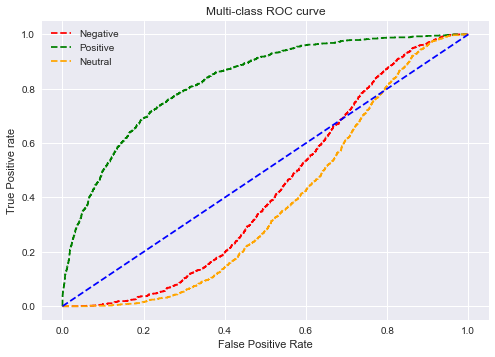

In [203]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')


random_probs = [0 for i in range(len(ytest))]
p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=i)

# plot roc curves
plt.plot(fpr0, tpr0, linestyle='--',color='red', label='Negative')
plt.plot(fpr1, tpr1, linestyle='--',color='green', label='Positive')
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label='Neutral')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')



# title
plt.title('Multi-class ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();